Copyright (c) 2021 April M. Misch <<miksch@theochem.uni-stuttgart.de>>, Alex Urban <<a.urban@columbia.edu>>, and Nong Artrith <<nartrith@atomistic.net>><br/>
Distributed under the terms of the Mozilla Public License, version 2.0 (https://www.mozilla.org/en-US/MPL/2.0/)

----


This notebook is a companion to Miksch, Morawietz, Kaestner, Urban, Artrith, to be published (2021).

The tutorial demonstrates the construction of an artificial neural network (ANN) interatomic potential for water clusters with six water molecules, using the data set from [1].

[1] A. M. Cooper, J. Kästner, A. Urban, N. Artrith, npj Comput. Mater. 6, 54 (2020);<br/> Data: https://archive.materialscloud.org/record/2020.0037/v1

# Prerequisites - installation of ænet and ASE

We will use the atomic energy network (ænet) package (http://ann.atomistic.net) artificial neural network (ANN) potential package

    N. Artrith and A. Urban, Comput. Mater. Sci. 114 (2016) 135-150.
    N. Artrith, A. Urban, and G. Ceder, Phys. Rev. B 96 (2017) 014112.

and the atomic simulation environment (ASE) package (https://wiki.fysik.dtu.dk/ase) for structure manipulation and to perform MD simulations

    Larsen et al., J. Phys.: Condens. Matter Vol. 29 273002, 2017

Also *clone* the companion GitHub repository with files for this tutorial (https://github.com/atomisticnet/MLP-beginners-guide).

In [1]:
try:
  import aenet
  print("successfully imported aenet")
except ImportError:
  !! git clone https://github.com/atomisticnet/aenet.git
  !! cd aenet/lib && make
  !! cd aenet/src && make -f makefiles/Makefile.gfortran_serial
  !! cd aenet/src && make -f makefiles/Makefile.gfortran_serial lib
  !! cd aenet/python3 && python3 setup.py build_ext --inplace
  !! cd aenet/python3 && pip install -e . --user
  print("completed installation of aenet")

completed installation of aenet


In [2]:
try:
  import ase
  print("successfully imported ase")
except ImportError:
  !! pip install ase --user --upgrade
  print("completed installing ASE")

completed installing ASE


Get additional materials for this tutorial from GitHub (https://github.com/atomisticnet/MLP-beginners-guide).

In [3]:
import os
if not os.path.exists('MLP-beginners-guide'):
  !! git clone https://github.com/atomisticnet/MLP-beginners-guide.git
else:
  print("Tutorial files are already installed.")

Now: Notebook has to be restarted to activate the packages that we just installed.

In [1]:
try:
  import aenet
  import ase
  print("Both aenet and ase could be imported. You are all set for the tutorial.")
except ImportError:
  print("The notebook needs to be restarted. Run this cell again once the restart is done.")
  import os
  os.kill(os.getpid(), 9)

Both aenet and ase could be imported. You are all set for the tutorial.


# Python imports

We need to import Python packages/libaries that we will use below.

In [2]:
import numpy as np
import pandas as pd
import re
from IPython.display import Image
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({"font.size": 15})
plt.close("all")

# 01-generate: Generating the reference data set

The first step is the transformation of the atomic structures in the reference data set into a feature-vector representation of local atomic environments.  This is done with the ænet tool `generate.x`.

We enter a subdirectory in which we will generate the reference data set.

In [3]:
%cd /content/MLP-beginners-guide/tutorial/01_generate/
%ls

/content/MLP-beginners-guide/tutorial/01_generate
generate.in        O.fingerprint.stp  sort-list.dat
H.fingerprint.stp  output/            Stuttgart-HCP-generate.in


`generate.x` is a command-line tool that reads input parameters from text files. The file `generate.in` is the pricipal input file containing information about the chemical species and the structures in the reference data set:

- The name of the *training set* output file to be generated,
- Atomic energies for each species that are subtracted from the total energy before the potential is trained,
- The file names of the *fingerprint* set-ups for each species that define how the local atomic environment is described, and
- The paths of the atomic structure files in the reference data set.

For more details, see also the aenet documentation: http://ann.atomistic.net/documentation/

In [4]:
! head -n 15 generate.in

OUTPUT H2O.train

TYPES
2
H 0.000000000
O 0.000000000

SETUPS
H    H.fingerprint.stp
O    O.fingerprint.stp

FILES
1886
../water-clusters-BLYP-D3/train_2000_xsf/train0500_1.xsf
../water-clusters-BLYP-D3/train_2000_xsf/train0500_10.xsf


Let's take a look at the *fingerprint* set-up file for oxygen.  The one for hydrogen is similar.  This example uses

- A BP2011 descriptor [1] with 30 symmetry functions of type 2 and 4,
- The radial cutoff distance is set to 12 Bohr (6.35 Å), and
- The minimal distance between atoms is set to be 0.75 Bohr (0.4 Å).

[1] J. Behler, [J. Chem. Phys. 134, 074106 (2011)](https://doi.org/10.1063/1.3553717).

**Note:** The water reference data uses the units Hartree and Bohr for energies and lenghts.  aenet ANN potentials are agnostic to the choice of units, but the aenet will (incorrectly) report electronvolts (eV) and Angstrom (Å) units in its output files.

In [5]:
! cat O.fingerprint.stp

DESCR
  Structural fingerprint setup for O in bulk TiO2.
  Ref.: N. Artrith and A. Urban, Comp. Mater. Sci. (2016)
END DESCR

ATOM O

ENV  2
H
O

RMIN 0.75d0

SYMMFUNC type=Behler2011
30
G=2 type2=H   eta=0.001  Rs=0.0000  Rc=12.0000
G=2 type2=O   eta=0.001  Rs=0.0000  Rc=12.0000
G=2 type2=H   eta=0.010  Rs=0.0000  Rc=12.0000
G=2 type2=O   eta=0.010  Rs=0.0000  Rc=12.0000
G=2 type2=H   eta=0.030  Rs=0.0000  Rc=12.0000
G=2 type2=O   eta=0.030  Rs=0.0000  Rc=12.0000
G=2 type2=H   eta=0.090  Rs=0.0000  Rc=12.0000
G=2 type2=O   eta=0.090  Rs=0.0000  Rc=12.0000
G=2 type2=H   eta=0.150  Rs=0.9000  Rc=12.0000
G=2 type2=O   eta=0.150  Rs=4.0000  Rc=12.0000
G=2 type2=H   eta=0.300  Rs=0.9000  Rc=12.0000
G=2 type2=O   eta=0.300  Rs=4.0000  Rc=12.0000
G=2 type2=H   eta=0.600  Rs=0.9000  Rc=12.0000
G=2 type2=O   eta=0.600  Rs=4.0000  Rc=12.0000
G=2 type2=H   eta=1.500  Rs=0.9000  Rc=12.0000
G=2 type2=O   eta=1.500  Rs=4.0000  Rc=12.0000
G=4 type2=H  type3=O    eta=0.001 lambda= -1.0  zeta= 4.0  Rc

In this example, everything is already prepared to start with the reference data set generation.  So, we can simply run `generate.x` and wait until all structures have been processed.  We collect the output that `generate.x` prints to the screen in a file named `generate.out`.  Note that this can take a minute:

In [6]:
! /content/aenet/bin/generate.x-2.0.4-gfortran_serial generate.in > generate.out
print("Reference data set generation completed.")
%ls

Reference data set generation completed.
generate.in   H2O.train          O.fingerprint.stp  sort-list.dat
generate.out  H.fingerprint.stp  output/            Stuttgart-HCP-generate.in


The training-set file `H2O.train` has been generated. **Note that training-set files are binary files and cannot be opened with a text editor.**

Now, we are ready to train our H2O cluster potential.  Let's return to the main directory.

In [7]:
%cd /content/

/content


# 02-train: Training an ANN potential

In this section, we will use the reference data set generated in the previous section to train an artificial neural network (ANN) potential.

Potential training is also done with a command-line tool, which is named `train.x`.  

In [8]:
%cd /content/MLP-beginners-guide/tutorial/02_train/
%ls

/content/MLP-beginners-guide/tutorial/02_train
train.in


An input file for `train.x`, named `train.in`, has already been prepared for us.  This file contains the following instructions

- The path to the reference data set file (`H2O.train`),
- The fraction of the data set that should be set aside as validation set,
- The number of training iterations (epochs) to perform,
- The training method and its parameters, and
- The *architecture* of the atomic-energy ANNs for each species.

For more details, see also the aenet documentation: http://ann.atomistic.net/documentation/

In [9]:
%cat train.in

TRAININGSET H2O.train
TESTPERCENT 10
ITERATIONS  100 

METHOD
bfgs

SAVE_ENERGIES

NETWORKS
! atom   network         hidden
! types  file-name       layers  nodes:activation
  O      O.10t-10t.nn    2       10:tanh 10:tanh
  H      H.10t-10t.nn    2       10:tanh 10:tanh



Before we can start with training, the reference data set file needs to be made available.  We will create a symbolic link to it in the present directory.

In [10]:
! ln -s /content/MLP-beginners-guide/tutorial/01_generate/H2O.train
%ls

H2O.train@  train.in


Now, we perform the training.  Note that this can take a few minutes.  We can observe the training iterations.

In [11]:
! /content/aenet/bin/train.x-2.0.4-gfortran_serial train.in | tee train.out
!! tar cfvz nn.tar.gz *.nn-* && rm -f *.nn-*
%ls

                       Training process started.                       
                                                                       
                          2021-03-26  01:11:28                         
                                                                       

 Copyright (C) 2015-2018 Nongnuch Artrith and Alexander Urban

 This program is distributed in the hope that it will be useful, but
 WITHOUT ANY WARRANTY; without even the implied warranty of
 MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
 Mozilla Public License, v. 2.0, for more details.

 ----------------------------------------------------------------------
                       Training set normalization                      
 ----------------------------------------------------------------------

 The training set will be normalized now.  Depending on its size this
 process can take a while.  The normalized data set will be written to
 another file. Load that file in future to avo

Once training has completed, the ANN potentials for oxygen and hydrogen are available in `O.10t-10t.nn` and `H.10t-10t.nn`.  **Note that ANN potential files are binary and cannot be open in a text editor.** 

In [12]:
%cd /content/

/content


# Analyzing the training results

Was the training successful?  One measure is the performance of the trained potential on the validation set, which is reported for each training epoch on lines that like the following:

    N  MAE_train  RMSE_train  MAE_val  RMSE_val  <

`N` is the training iteration (or *epoch*), `MAE_train` and `RMSE_train` are the *mean absolute error* and *root mean squared error* on the training set, and `MAE_val` and `RMSE_val` are the same for the validation set.

**Note:** As explained in the companion manuscript, the performance on the validation set is not necessarily a good estimate for the true accuracy of the ANN potential.  A more robust accuracy estimate should be obtained from testing on an independently generated test set.

Plotting the RMSE of both training and validation set together can be helpful to detect overfitting.  

**Note:** As explained above, the energy unit in the water reference data set is Hartree, even though aenet reports electronvolts.

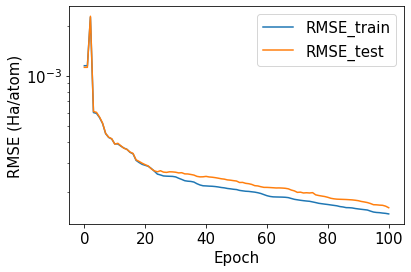

In [13]:
errors = []
with open("/content/MLP-beginners-guide/tutorial/02_train/train.out") as fp:
  for line in fp:
    if re.match("^ *[0-9].*<$", line):
      errors.append([float(a) for a in line.split()[1:-1]])
errors = np.array(errors)
errors = pd.DataFrame(
    data=errors, 
    columns=['MAE_train', 'RMSE_train', 'MAE_test', 'RMSE_test'])
ax = errors[['RMSE_train', 'RMSE_test']].plot(logy=True)
ax.set_xlabel("Epoch"); ax.set_ylabel("RMSE (Ha/atom)")
plt.show()

As seen in the figure, the training-set RMSE (`RMSE_train`) continues to decrease until the final training iteration.  The validation set RMSE (`RMSE_test`) also decreases but exhibits more noise.

## Comparison of training and validation errors

`train.x` can export the errors for all training samples in the training and validation sets.  Here, we visualize the results for one example (set003).

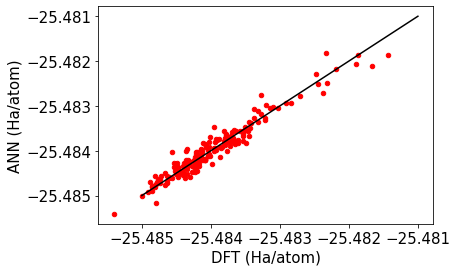

In [14]:
test = "/content/MLP-beginners-guide/tutorial/02_train/energies.test.0"
test_errors = np.loadtxt(test, skiprows=1, usecols=(3,4))
limits = np.linspace(-25.485, -25.481)
plt.plot(limits, limits, color="black")
plt.ticklabel_format(useOffset=False)
plt.scatter(test_errors[:,0], test_errors[:,1], color="red", s=20, label="validation")
plt.xlabel('DFT (Ha/atom)')
plt.ylabel('ANN (Ha/atom)')
plt.show()

# 04-anetLib-ann-md: The ænet-Python interface

Trained ænet ANN potentials can be used with a number of standard simulations packages.  Here we will take a look at the ænet Python interface, which enables compatibility with the Atomic Simulation Environment (ase, see above).

In [15]:
import aenet
from aenet.ase_calculator import ANNCalculator
import ase
import ase.spacegroup
import ase.visualize

We create a new directory and copy the trained potentials into it.

In [16]:
! mkdir -p /content/MLP-beginners-guide/tutorial/03_md
%cd /content/MLP-beginners-guide/tutorial/03_md
%ls

/content/MLP-beginners-guide/tutorial/03_md


Next, we create an ase structure object from one of the water cluster structures.

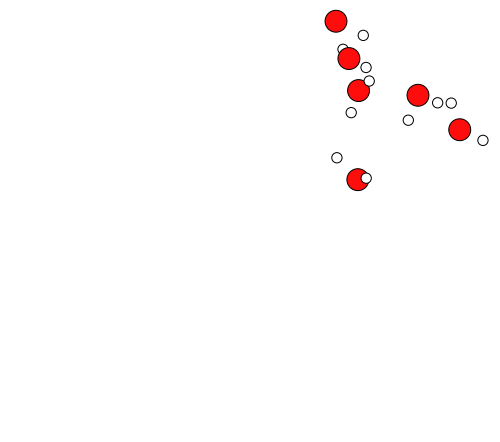

In [17]:
atoms = ase.io.read("/content/MLP-beginners-guide/tutorial/water-clusters-BLYP-D3/train_0500_xsf/train0500_1.xsf")
ase.io.write('6h2o.traj', atoms)
ase.io.write('6h2o.png', atoms)
Image("6h2o.png")
#ase.visualize.view(atoms, viewer='x3d')

The ænet Python package provides an ASE *Calculator* class that can load ænet ANN potentials.  In this case, we use an ANN potential that was trained with the same input file parameters as above but for more iterations.

In [18]:
pot = {"H": "/content/MLP-beginners-guide/tutorial/02_train/H.10t-10t.nn", 
       "O": "/content/MLP-beginners-guide/tutorial/02_train/O.10t-10t.nn"}
calc = ANNCalculator(pot)

This calculator can then be used to predict energies (and atomic forces) for a given atomic structure.

In [19]:
atoms.set_calculator(calc)
E = atoms.get_potential_energy()
print("Total energy = {} Ha".format(E))


Total energy = -458.68794485712954 Ha


In [20]:
%cd /content

/content


# Python/ASE Example: Molecular Dynamics Simulation

In this example, we use the `ANNCalculator` and ASE to perform a molecular dynamics (MD) simulation with constant energy (NVE ensemble).

**Note:** This is an educational example.  MD simulations with ASE in a Google Colab notebook are *not* very efficient.  For production simulations, an actual workstation is recommended.  Furthermore, ænet also provides a C-compatible library (*ænetLib*) that can be interfaced with other MD software [1].

[1] N. Artrith and A. Urban, [Comput. Mater. Sci. 114 (2016) 135-150](https://doi.org/10.1016/j.commatsci.2015.11.047).

In [21]:
%cd /content/MLP-beginners-guide/tutorial/03_md

/content/MLP-beginners-guide/tutorial/03_md


The next cell runs the MD simulation.  Note that the instructions are purely based on ASE and are not specific to ænet.

The MD simulation is performed in the microcanonical NVE ensemble, i.e., the cell volume and total energy are kept constant.  We use a time step of 0.25 femtoseconds for the integration of the integration of motion with the *velocity Verlet* algorithm.  Atomic momenta are initialized according to a Maxwell-Boltzmann distribution at a temperature of 300 K.

**Note:** It can be required to execute the following cell twice.

In [23]:
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.md.verlet import VelocityVerlet
from ase.units import kB, fs
import aenet

pot = {"H": "/content/MLP-beginners-guide/tutorial/02_train/H.10t-10t.nn", 
       "O": "/content/MLP-beginners-guide/tutorial/02_train/O.10t-10t.nn"}

calc = ANNCalculator(pot)

dt = 0.25  # 0.25 fs time step
T = 300.0  # 300 K temperature

md_atoms = ase.io.read("6h2o.traj")
md_atoms.set_calculator(calc)
MaxwellBoltzmannDistribution(md_atoms, T*kB)
dyn = VelocityVerlet(md_atoms, dt*fs)

md_step = 0

def printenergy(atoms=md_atoms, i=[0.0, dt/1000]):
  """ Print status at each MD step. """
  E_pot = atoms.get_potential_energy()/len(atoms)
  E_kin = atoms.get_kinetic_energy()/len(atoms)
  E_tot = E_pot + E_kin
  T = E_kin/(1.5*kB)
  print("{:6.3f}  {:6.1f}  {:15.3f}  {:15.3f}  {:15.3f}".format(
        i[0], T, E_pot, E_kin, E_tot))
  i[0] += i[1]

print("t (ps)   T (K)  E_pot (Ha/atom)  E_kin (Ha/atom)  E_tot (Ha/atom)")
dyn.attach(printenergy, interval=1)
printenergy()
dyn.run(100)

/root/.local/lib/python3.7/site-packages/ase/md/md.py:48: FutureWarning: Specify the temperature in K using the 'temperature_K' argument
  warnings.warn(FutureWarning(w))


t (ps)   T (K)  E_pot (Ha/atom)  E_kin (Ha/atom)  E_tot (Ha/atom)
 0.000   285.4          -25.483            0.037          -25.446
 0.000   285.4          -25.483            0.037          -25.446
 0.001   285.4          -25.483            0.037          -25.446
 0.001   285.3          -25.483            0.037          -25.446
 0.001   285.2          -25.483            0.037          -25.446
 0.001   285.1          -25.483            0.037          -25.446
 0.002   284.9          -25.483            0.037          -25.446
 0.002   284.7          -25.483            0.037          -25.446
 0.002   284.5          -25.483            0.037          -25.446
 0.002   284.2          -25.483            0.037          -25.446
 0.003   283.9          -25.482            0.037          -25.446
 0.003   283.5          -25.482            0.037          -25.446
 0.003   283.2          -25.482            0.037          -25.446
 0.003   282.8          -25.482            0.037          -25.446
 0.004   2

True

We can now take a look at the final structure.  

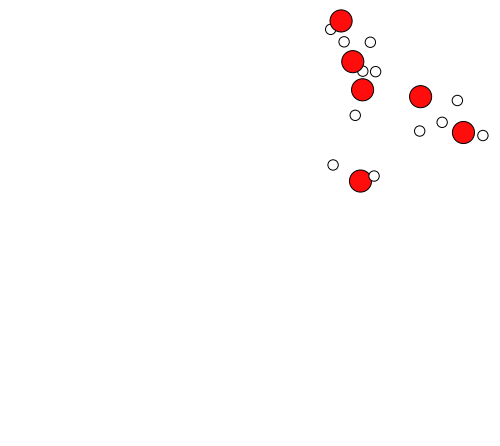

In [27]:
ase.io.write('6h2o-md.png', md_atoms)
Image("6h2o-md.png")
#ase.visualize.view(md_atoms, viewer='x3d')

In [25]:
%cd /content/

/content


# Caution

This tutorial is purely an educational example, and the constructed ANN potential cannot be expected to be robust.  Longer training (more iterations) and extensive testing would be required.